In [ ]:
#we didnt mangage to get live plot running
#the code is in there somehow it doesnt work,
#although it should:D

In [41]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:


tf.reset_default_graph()

#Placeholder which are different for each run.
x = tf.placeholder(tf.float32, [4])
x_exp = tf.expand_dims(x, axis=0 )

#Variables which are adjusted during the learning


with tf.variable_scope('Layer1'):
    
    weights = tf.Variable(tf.truncated_normal([4, 8], stddev=0.2))
    biases = tf.Variable(tf.constant(1.0, shape=[8]) )
    
    layer1 = tf.nn.relu(tf.matmul(x_exp, weights) + biases)
    
    
with tf.variable_scope('Layer2'):
    
    weights = tf.Variable(tf.truncated_normal([8,1], stddev=0.2))
    biases = tf.Variable(tf.constant(1.0, shape=[1]))
    
    layer2 = tf.sigmoid(tf.matmul(layer1, weights) + biases)
    
    
prob_left = layer2
prob_right = 1 - layer2
action_probs = tf.concat([prob_left, prob_right], axis=1)
log_likelihoods = tf.log(action_probs)

# sample an action and get corresponding log-likelihood
action = tf.multinomial(log_likelihoods,num_samples = 1)[0][0]
log_likelihood = log_likelihoods[:, tf.to_int32(action)]






# create the optimizer object 
learningRate = 0.1
optimizer = tf.train.AdamOptimizer(learningRate)
gradients_and_variables = optimizer.compute_gradients(log_likelihood)

#print(gradients_and_variables[16])
gradients = [gradient_and_variable[0] * -1
              for gradient_and_variable 
              in gradients_and_variables
            ]

gradient_placeholders = []
for gradient in gradients:
    gradient_placeholders.append(tf.placeholder(tf.float32, gradient.shape))

trainable_variables = tf.trainable_variables()
training_step = optimizer.apply_gradients(zip(gradient_placeholders, trainable_variables))



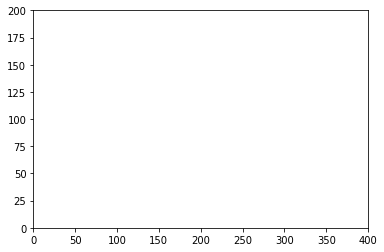

KeyboardInterrupt: 

In [43]:
# HYPERPARAMETERS
batches = 40
batch_size = 10

discount_factor = 0.9


# Create new environment instance
env = gym.make("CartPole-v0")


xplt = []
yplt = []

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis([0,400,0,200])
plot, = ax.plot(xplt, yplt)


plt.show()





with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step=-1

    for batch_episode in range(batches):
    
        batch_grads = []
    
        for episode in range(batch_size):
            step += 1
            # reset game
            observation = env.reset()
            done = False

            # reward and gradient buffer
            reward_buff = []
            gradient_buff = []

            while not done:

                # render current game state 
                env.render()

                # sample action from network
                sampled_action, retrieved_gradients = sess.run(
                                        [action, gradients], 
                                        feed_dict={x: observation}
                                    )
                

                # Execute action and receive the corresponding reward 
                # and a new observation
                observation, reward, done, info = env.step(sampled_action)
                

                # store reward and gradient
                reward_buff.append(reward)
                gradient_buff.append(retrieved_gradients)

            discounted_rewards = discount_rewards(
                                    reward_buff, discount_factor
                                 )

            
            #storing the number of the episode and the first of the discounted
            #rewards for plotting
            xplt.append(step)
            yplt.append(discounted_rewards[0])
            

            # normalize the discounted rewards
            mn = np.mean(discounted_rewards)
            std = np.std(discounted_rewards)
            discounted_rewards = (discounted_rewards - mn)/std

            #epxand dims and tile to fit the shape of gradient buff
            discounted_rewards = np.expand_dims(discounted_rewards, axis=1)
            discounted_rewards = np.tile(discounted_rewards, [1,4])

            #create the policy gradients
            policy_grads = sum(discounted_rewards * gradient_buff)
            #store the policy_grads
            batch_grads.append(policy_grads)
            
            
        
        # apply the stored gradients one by one
        for policy_grads in batch_grads:
            
            _ = sess.run([training_step],
                        feed_dict={
                            gradient_placeholders[0]: policy_grads[0],
                            gradient_placeholders[1]: policy_grads[1],
                            gradient_placeholders[2]: policy_grads[2],
                            gradient_placeholders[3]: policy_grads[3]
                            
                        })
         
        
        
        plot.set_xdata(xplt)
        plot.set_ydata(yplt)
        fig.canvas.draw()

        

In [7]:
def discount_rewards(rewards, gamma):
    
    # rewards are given as a list and returned as a numpy array
    discounted_rewards = []
    
    for i, reward in enumerate(rewards):
        relevant_rewards = rewards[i:]
        discounted = sum([gamma**n * relevant_reward 
                        for n, relevant_reward 
                        in enumerate(relevant_rewards)
                     ])
        discounted_rewards.append(discounted)
        
    return np.array(discounted_rewards)
        
        